In [1]:
import numpy as np
import pandas as pd
import os
import math

from sas7bdat import SAS7BDAT

pd.set_option('display.max_rows', 300, 'display.max_columns', 300)
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import adabound
from pycox.evaluation.concordance import concordance_td
from sklearn.metrics import accuracy_score, roc_auc_score
from lifelines import KaplanMeierFitter, NelsonAalenFitter, AalenJohansenFitter
torch.cuda.is_available()

True

In [2]:
class RAdam(optim.Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0, degenerated_to_sgd=True):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        
        self.degenerated_to_sgd = degenerated_to_sgd
        if isinstance(params, (list, tuple)) and len(params) > 0 and isinstance(params[0], dict):
            for param in params:
                if 'betas' in param and (param['betas'][0] != betas[0] or param['betas'][1] != betas[1]):
                    param['buffer'] = [[None, None, None] for _ in range(10)]
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay, buffer=[[None, None, None] for _ in range(10)])
        super(RAdam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(RAdam, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('RAdam does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                state['step'] += 1
                buffered = group['buffer'][int(state['step'] % 10)]
                if state['step'] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2 ** state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma

                    # more conservative since it's an approximated value
                    if N_sma >= 5:
                        step_size = math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    elif self.degenerated_to_sgd:
                        step_size = 1.0 / (1 - beta1 ** state['step'])
                    else:
                        step_size = -1
                    buffered[2] = step_size

                # more conservative since it's an approximated value
                if N_sma >= 5:
                    if group['weight_decay'] != 0:
                        p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    p_data_fp32.addcdiv_(-step_size * group['lr'], exp_avg, denom)
                    p.data.copy_(p_data_fp32)
                elif step_size > 0:
                    if group['weight_decay'] != 0:
                        p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)
                    p_data_fp32.add_(-step_size * group['lr'], exp_avg)
                    p.data.copy_(p_data_fp32)

        return loss

## 1. Import the data

In [3]:
dat = SAS7BDAT('D:/Cho Lab Dropbox/연구원별정리/이다혜/07 CRDW/00. Data/cancer_c56_210713_a.sas7bdat').to_data_frame()

In [4]:
X_dat = dat[['SEERCODE_1',
             'MODIF2_PHIS_HTN_YN_2YR',
             'MODIF2_PHIS_DEPR_YN_2YR',
             'MODIF2_PHIS_DM_YN_2YR',
             'MODIF_MRTL_YN_2YR',
             'drink_modif',
             'smok_modif2',
             'AGE_C',
             'histology',
             'FIGO_grp'
            ]]

### 1.1 Create event variable (for cause-specific analysis)  
* VTE 1년 이내 발생=1 / 그외=0

In [5]:
dat['YN_2GRP_I26_I802_I82_1YR'] = np.where(dat['CR_VTE_1YR'] ==1, 1, 0)

* Create event time data (time_dat), event indicator data (event_dat), year of diagnosis data(DIA_YEAR)

In [6]:
time_dat = dat['M_TIME_VTE_1YR']
event_dat = dat['YN_2GRP_I26_I802_I82_1YR']
DIA_YEAR = dat['DIA_YEAR']

time_dat2 = np.int32(time_dat) - 1
ntime = len(np.unique(time_dat2))

#### CHECK: number of event = 1 (cause-specific analysis)

In [7]:
num_event = 1

### 1.2 Categorize BMI, STAY_DRTN variables

In [8]:
X_dat['BMI_GRP2'] = np.where(dat['MODIF_VS2_BMI_2YR'] < 25, 1, 0)
X_dat['BMI_GRP2'] = np.where((dat['MODIF_VS2_BMI_2YR'] >= 25), 2, X_dat['BMI_GRP2'])

X_dat['STAY_DRTN_GRP'] = np.where(dat['STAY_DRTN'] >= 15, 1, 0)

<ipython-input-8-d4be90d0eeea>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_dat['BMI_GRP2'] = np.where(dat['MODIF_VS2_BMI_2YR'] < 25, 1, 0)
<ipython-input-8-d4be90d0eeea>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_dat['BMI_GRP2'] = np.where((dat['MODIF_VS2_BMI_2YR'] >= 25), 2, X_dat['BMI_GRP2'])
<ipython-input-8-d4be90d0eeea>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

In [9]:
contvar = ["AGE_C"]
#contvar = ["age_c"]
catevar= X_dat.columns[[x not in contvar for x in X_dat.columns]]

X_dat2 = X_dat.copy()
X_dat2[catevar] = X_dat2[catevar].astype("category")
X_dat2.dtypes

SEERCODE_1                 category
MODIF2_PHIS_HTN_YN_2YR     category
MODIF2_PHIS_DEPR_YN_2YR    category
MODIF2_PHIS_DM_YN_2YR      category
MODIF_MRTL_YN_2YR          category
drink_modif                category
smok_modif2                category
AGE_C                       float64
histology                  category
FIGO_grp                   category
BMI_GRP2                   category
STAY_DRTN_GRP              category
dtype: object

In [10]:
X_dat3 = pd.get_dummies(X_dat2, columns = catevar, drop_first = True)
fixed_dat = X_dat3.to_numpy()

nsubject = fixed_dat.shape[0]
print(fixed_dat.shape, nsubject)

(1268, 27) 1268


## 2. Longitudinal variable for static model  
* Baseline으로 관측된 가장 첫 달 값 사용 변수: `OP_TIME_dat`, `CT_약제명_dat`
* Baseline으로 한 번이라도 관측된 값이 있으면 그 값을 사용: Binary (Yes/No or Normal/Abnormal) 변수 `OP_dat`, `TF_dat`, `RT_dat`, `OP_surgery_other`, 혈액변수들 (`WBC`, `Hb`, `Plt`, `CA125`)
* Baseline 항암 치료제 총 투여량: sum

In [11]:
'''
(1) Binary 변수: 한 번이라도 관측된 값이 있으면 그 값을 baseline으로 사용
OP_dat: 진단 후 1~12개월 째 수술 여부
TF_dat: 진단 후 1~12개월 째 수술 당시 수혈 여부
RT_dat: 진단 후 1~12개월 째 방사선 치료 여부
WBC
Hb
Plt
CA125
OP_surgery_other

(2) Continuous 변수: 전체 시점 총합을 baseline으로 사용
DOSE_dat: 진단 후 1~12개월 째 투약된 dose 양

(3) Categorical 변수: 관측된 가장 첫번째 시점의 값을 baseline으로 사용
OP_TIME_dat: 진단 후 1~12개월 째 받은 수술 시간 (해당 월)
CT_약제명_dat
Ddimer

'''
OP_surgery = dat[['OP{}'.format(i) + '_SURGERY_AREA' for i in range(1,13)]] #모형에 사용하지 않고 대신 op_surgery_other를 씀

## (1) Binary 변수
OP_dat = dat[['OP_{}'.format(i) for i in range(1,13)]]
TF_dat = dat[['OP_TF_MON{}'.format(i) for i in range(1,13)]]
RT_dat = dat[['RT_MON{}'.format(i) for i in range(1,13)]]

WBC_MIN_normal = np.where(dat[['minWBC_{}'.format(i) for i in range(1,13)]] == 0, 1, 0)
WBC_MAX_normal = np.where(dat[['maxWBC_{}'.format(i) for i in range(1,13)]] == 0, 1, 0)
WBC_MED_normal = np.where(dat[['medianWBC_{}'.format(i) for i in range(1,13)]] == 0, 1, 0)
WBC_MIN_abnormal = np.where(dat[['minWBC_{}'.format(i) for i in range(1,13)]] == 1, 1, 0)
WBC_MAX_abnormal = np.where(dat[['maxWBC_{}'.format(i) for i in range(1,13)]] == 1, 1, 0)
WBC_MED_abnormal = np.where(dat[['medianWBC_{}'.format(i) for i in range(1,13)]] == 1, 1, 0)

Hb_MIN_normal = np.where(dat[['minHb_{}'.format(i) for i in range(1,13)]] == 0, 1, 0)
Hb_MAX_normal = np.where(dat[['maxHb_{}'.format(i) for i in range(1,13)]] == 0, 1, 0)
Hb_MED_normal = np.where(dat[['medianHb_{}'.format(i) for i in range(1,13)]] == 0, 1, 0)
Hb_MIN_abnormal = np.where(dat[['minHb_{}'.format(i) for i in range(1,13)]] == 1, 1, 0)
Hb_MAX_abnormal = np.where(dat[['maxHb_{}'.format(i) for i in range(1,13)]] == 1, 1, 0)
Hb_MED_abnormal = np.where(dat[['medianHb_{}'.format(i) for i in range(1,13)]] == 1, 1, 0)

PLT_MIN_normal = np.where(dat[['minPLT_{}'.format(i) for i in range(1,13)]] == 0, 1, 0)
PLT_MAX_normal = np.where(dat[['maxPLT_{}'.format(i) for i in range(1,13)]] == 0, 1, 0)
PLT_MED_normal = np.where(dat[['medianPLT_{}'.format(i) for i in range(1,13)]] == 0, 1, 0)
PLT_MIN_abnormal = np.where(dat[['minPLT_{}'.format(i) for i in range(1,13)]] == 1, 1, 0)
PLT_MAX_abnormal = np.where(dat[['maxPLT_{}'.format(i) for i in range(1,13)]] == 1, 1, 0)
PLT_MED_abnormal = np.where(dat[['medianPLT_{}'.format(i) for i in range(1,13)]] == 1, 1, 0)

CA125_MIN_normal = np.where(dat[['minCA125_{}'.format(i) for i in range(1,13)]] == 0, 1, 0)
CA125_MAX_normal = np.where(dat[['maxCA125_{}'.format(i) for i in range(1,13)]] == 0, 1, 0)
CA125_MED_normal = np.where(dat[['medianCA125_{}'.format(i) for i in range(1,13)]] == 0, 1, 0)
CA125_MIN_abnormal = np.where(dat[['minCA125_{}'.format(i) for i in range(1,13)]] == 1, 1, 0)
CA125_MAX_abnormal = np.where(dat[['maxCA125_{}'.format(i) for i in range(1,13)]] == 1, 1, 0)
CA125_MED_abnormal = np.where(dat[['medianCA125_{}'.format(i) for i in range(1,13)]] == 1, 1, 0)

## Ddimer
Ddimer_MIN_abnormal = dat[['minDdimer_{}'.format(i) for i in range(1,13)]]
Ddimer_MAX_abnormal = dat[['maxDdimer_{}'.format(i) for i in range(1,13)]]
Ddimer_MED_abnormal = dat[['medianDdimer_{}'.format(i) for i in range(1,13)]]

OP_surgery_other = np.where(OP_surgery == 5, 1, 0)

## (2) Continuous 변수
DOSE_dat = dat[['CT_DOSE_{}'.format(i) for i in range(1,13)]]

## (3) 
OP_TIME_dat = dat[['OP{}'.format(i) + '_TIME_MIN' for i in range(1,13)]]

# 진단 후 1~12개월 째 약제별 투약 횟수
CT_TAXO_dat = dat[['CT_TAXO_MON{}'.format(i) for i in range(1,13)]]
CT_CARB_dat = dat[['CT_CARB_MON{}'.format(i) for i in range(1,13)]]
CT_ADRL2_dat = dat[['CT_ADRL2_MON{}'.format(i) for i in range(1,13)]]
CT_TPTC_dat = dat[['CT_TPTC_MON{}'.format(i) for i in range(1,13)]]
CT_BVCZ_dat = dat[['CT_BVCZ_MON{}'.format(i) for i in range(1,13)]]
CT_DCT_dat = dat[['CT_DCT_MON{}'.format(i) for i in range(1,13)]]
CT_BELTC_dat = dat[['CT_BELTC_MON{}'.format(i) for i in range(1,13)]]
CT_NVB_dat = dat[['CT_NVB_MON{}'.format(i) for i in range(1,13)]]
CT_IRNT_dat = dat[['CT_IRNT_MON{}'.format(i) for i in range(1,13)]]
CT_ADRS_dat = dat[['CT_ADRS_MON{}'.format(i) for i in range(1,13)]]
CT_ADR_dat = dat[['CT_ADR_MON{}'.format(i) for i in range(1,13)]]
CT_VP_dat = dat[['CT_VP_MON{}'.format(i) for i in range(1,13)]]
CT_CPM_dat = dat[['CT_CPM_MON{}'.format(i) for i in range(1,13)]]
CT_IFO_dat = dat[['CT_IFO_MON{}'.format(i) for i in range(1,13)]]
CT_CDDP_dat = dat[['CT_CDDP_MON{}'.format(i) for i in range(1,13)]]
CT_FU_dat = dat[['CT_FU_MON{}'.format(i) for i in range(1,13)]]
CT_MTX_dat = dat[['CT_MTX_MON{}'.format(i) for i in range(1,13)]]
CT_VCR_dat = dat[['CT_VCR_MON{}'.format(i) for i in range(1,13)]]

timevar_dat = np.zeros(shape = [X_dat.shape[0], 12, 51])

## Binary covariates
timevar_dat[:,:, 0] = OP_dat.copy()
timevar_dat[:,:, 1] = TF_dat.copy()
timevar_dat[:,:, 2] = RT_dat.copy()
timevar_dat[:,:, 3] = OP_surgery_other.copy()

timevar_dat[:,:, 4] = WBC_MIN_normal.copy() 
timevar_dat[:,:, 5] = WBC_MAX_normal.copy() 
timevar_dat[:,:, 6] = WBC_MED_normal.copy()
timevar_dat[:,:, 7] = WBC_MIN_abnormal.copy() 
timevar_dat[:,:, 8] = WBC_MAX_abnormal.copy() 
timevar_dat[:,:, 9] = WBC_MED_abnormal.copy() 
timevar_dat[:,:,10] = Hb_MIN_normal.copy()
timevar_dat[:,:,11] = Hb_MAX_normal.copy() 
timevar_dat[:,:,12] = Hb_MED_normal.copy() 
timevar_dat[:,:,13] = Hb_MIN_abnormal.copy() 
timevar_dat[:,:,14] = Hb_MAX_abnormal.copy() 
timevar_dat[:,:,15] = Hb_MED_abnormal.copy() 
timevar_dat[:,:,16] = PLT_MIN_normal.copy() 
timevar_dat[:,:,17] = PLT_MAX_normal.copy() 
timevar_dat[:,:,18] = PLT_MED_normal.copy() 
timevar_dat[:,:,19] = PLT_MIN_abnormal.copy() 
timevar_dat[:,:,20] = PLT_MAX_abnormal.copy() 
timevar_dat[:,:,21] = PLT_MED_abnormal.copy() 
timevar_dat[:,:,22] = CA125_MIN_normal.copy()
timevar_dat[:,:,23] = CA125_MAX_normal.copy() 
timevar_dat[:,:,24] = CA125_MED_normal.copy() 
timevar_dat[:,:,25] = CA125_MIN_abnormal.copy() 
timevar_dat[:,:,26] = CA125_MAX_abnormal.copy()
timevar_dat[:,:,27] = CA125_MED_abnormal.copy() 

timevar_dat[:,:,28] = Ddimer_MIN_abnormal.copy()
timevar_dat[:,:,29] = Ddimer_MAX_abnormal.copy()
timevar_dat[:,:,30] = Ddimer_MED_abnormal.copy()

# Baseline으로 총합 or 평균값 사용할 변수
timevar_dat[:,:,31] = DOSE_dat.copy()

# Baseline으로 관측된 첫 달 값 사용
timevar_dat[:,:,32] = CT_TAXO_dat.copy() 
timevar_dat[:,:,33] = CT_CARB_dat.copy() 
timevar_dat[:,:,34] = CT_ADRL2_dat.copy()
timevar_dat[:,:,35] = CT_TPTC_dat.copy() 
timevar_dat[:,:,36] = CT_BVCZ_dat.copy() 
timevar_dat[:,:,37] = CT_DCT_dat.copy() 
timevar_dat[:,:,38] = CT_BELTC_dat.copy()
timevar_dat[:,:,39] = CT_NVB_dat.copy() 
timevar_dat[:,:,40] = CT_IRNT_dat.copy() 
timevar_dat[:,:,41] = CT_ADRS_dat.copy() 
timevar_dat[:,:,42] = CT_ADR_dat.copy() 
timevar_dat[:,:,43] = CT_VP_dat.copy() 
timevar_dat[:,:,44] = CT_CPM_dat.copy() 
timevar_dat[:,:,45] = CT_IFO_dat.copy() 
timevar_dat[:,:,46] = CT_CDDP_dat.copy() 
timevar_dat[:,:,47] = CT_FU_dat.copy() 
timevar_dat[:,:,48] = CT_MTX_dat.copy() 
timevar_dat[:,:,49] = CT_VCR_dat.copy() 

timevar_dat[:,:,50] = OP_TIME_dat.copy() 

In [12]:
mask_dat = np.zeros([nsubject, ntime, timevar_dat.shape[-1]], dtype=bool)
for i in range(nsubject):
    mask_dat[i, :time_dat2[i], :] = 1
    
obs_mask_dat = mask_dat * ~np.isnan(timevar_dat)
timevar_dat[~obs_mask_dat] = 0
obs_mask_dat = np.any(timevar_dat, axis=2, keepdims=True) * obs_mask_dat
obs_mask_dat[:,0,:] = 1

#Baseline: 관측된 첫 달의 값 사용
first_time_dat = timevar_dat[:,:,32:]

#관측된 가장 첫 달 값을 baseline으로 저장
first_count = np.zeros((first_time_dat.shape[0], first_time_dat.shape[2])) #(1268, 19)
for i in range(first_time_dat.shape[2]):
    for j in range(first_time_dat.shape[0]):
        for k in range(first_time_dat.shape[1]):
            #if np.isnan(first_time_dat[j,k,i])==False:
            if first_time_dat[j,k,i]!=0:    
                first_count[j,i]=first_time_dat[j,k,i]
                break

timevar_flatten = np.zeros((nsubject, timevar_dat.shape[2]))
timevar_flatten_cand = timevar_dat * mask_dat
timevar_flatten[:,:31] = timevar_flatten_cand[:,:,:31].any(1)
timevar_flatten[:,31] = timevar_flatten_cand[:,:,31].sum(1)/ntime
timevar_flatten[:,32:] = first_count

total_dat = np.concatenate([fixed_dat, timevar_flatten], 1)

In [13]:
timevar_compact = np.zeros((nsubject, ntime, timevar_dat.shape[2] + 1))
obs_mask_compact = np.zeros((nsubject, ntime, timevar_dat.shape[2] + 1))
for index in range(nsubject):
    timevar_compact[index,:np.sum(obs_mask_dat[index,:,0]),:-1] = timevar_dat[index, obs_mask_dat[index,:,0], :]
    timevar_compact[index,:np.sum(obs_mask_dat[index,:,0])-1,-1] = np.diff(np.where(obs_mask_dat[index,:,0])[0])
    
    obs_mask_compact[index,:np.sum(obs_mask_dat[index,:,0]),:-1] = obs_mask_dat[index, obs_mask_dat[index,:,0], :]
    obs_mask_compact[index,:np.sum(obs_mask_dat[index,:,0]),-1] = 1
pd.DataFrame(timevar_compact[4,:,:])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
1,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,325.0,1.0
2,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
testcond = np.isin(DIA_YEAR, [2008, 2010, 2012, 2014, 2016])

total_train = total_dat[np.invert(testcond)].copy()
timevar_compact_train = timevar_compact[np.invert(testcond)].copy()
event_train = event_dat.values[np.invert(testcond)].copy()
time_train = time_dat2[np.invert(testcond)].copy()
obs_mask_compact_train = obs_mask_compact[np.invert(testcond)].copy()

total_test = total_dat[testcond].copy()
timevar_compact_test = timevar_compact[testcond].copy()
event_test = event_dat.values[testcond].copy()
time_test = time_dat2[testcond].copy()
obs_mask_compact_test = obs_mask_compact[testcond].copy()

ntrain = total_train.shape[0]
nsubject, ntrain, nsubject-ntrain

(1268, 678, 590)

In [15]:
train_max = total_train[:,[0]].max(0, keepdims=True)

total_train[:,[0]] = total_train[:,[0]]/train_max
total_test[:,[0]] = total_test[:,[0]]/train_max

train_max = total_train[:,fixed_dat.shape[-1]+31:].max(0, keepdims=True)

total_train[:,fixed_dat.shape[-1]+31:] = total_train[:,fixed_dat.shape[-1]+31:]/train_max
total_test[:,fixed_dat.shape[-1]+31:] = total_test[:,fixed_dat.shape[-1]+31:]/train_max

In [16]:
train_max_timevar = timevar_compact_train[:,:,31:].max(0, keepdims=True).max(1, keepdims=True)
timevar_compact_train[:,:,31:] = timevar_compact_train[:,:,31:] / train_max_timevar
timevar_compact_test[:,:,31:] = timevar_compact_test[:,:,31:] / train_max_timevar

In [17]:
batch_size = 256
hidden_size = 256

train_data = []
for i in range(ntrain):
    train_data.append([total_train[i], timevar_compact_train[i], event_train[i], time_train[i], obs_mask_compact_train[i]])
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, pin_memory=True)
train_loader

In [18]:
cuda = torch.cuda.is_available() # False
if cuda:
    device = 'cuda:0'
else:
    device = 'cpu'

In [19]:
class MLP(nn.Module):
    
    def __init__(self, input_size, hidden_size=128, num_layer=1, num_event=1):
        super(MLP, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layer = num_layer
        self.num_event = num_event
        
        self.hidden_in = nn.Linear(self.input_size, self.hidden_size)
        hiddens = [
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.LeakyReLU(inplace=True),
        ]
        self.hiddens = nn.Sequential(*((num_layer-1)*hiddens))
        self.hidden_out = nn.Linear(self.hidden_size, 1)
        self.activation = nn.LeakyReLU(inplace=True)
                
    def forward(self, x):
        ## x: (batch, input_size)

        batch_size = x.shape[0]
        x = self.hidden_in(x)
        x = self.hiddens(self.activation(x))
        x = self.hidden_out(x)
        
        return x

In [20]:
model = MLP(input_size=41, hidden_size=128, num_layer=2, num_event=num_event).to(device)
model

MLP(
  (hidden_in): Linear(in_features=41, out_features=128, bias=True)
  (hiddens): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
  )
  (hidden_out): Linear(in_features=128, out_features=1, bias=True)
  (activation): LeakyReLU(negative_slope=0.01, inplace=True)
)

In [21]:
y_pred = model(torch.rand(5, 41).to(device))
y_pred.shape

torch.Size([5, 1])

C:\Users\demel\anaconda3\envs\pytorch\lib\site-packages\adabound\adabound.py:94: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ..\torch\csrc\utils\python_arg_parser.cpp:1025.)
  exp_avg.mul_(beta1).add_(1 - beta1, grad)


Epoch: 0, Loss: 6.2416e-01
Epoch: 100, Loss: 2.1456e-01
Epoch: 200, Loss: 1.9491e-01
Epoch: 300, Loss: 1.8306e-01
Epoch: 400, Loss: 1.7794e-01
Epoch: 500, Loss: 1.7412e-01
Epoch: 600, Loss: 1.7414e-01
Epoch: 700, Loss: 1.6990e-01
Epoch: 800, Loss: 1.6240e-01
Epoch: 900, Loss: 1.6643e-01
Epoch: 1000, Loss: 1.5936e-01
Epoch: 1100, Loss: 1.6386e-01
Epoch: 1200, Loss: 1.6007e-01
Epoch: 1300, Loss: 1.6245e-01
Epoch: 1400, Loss: 1.5062e-01
Epoch: 1500, Loss: 1.4769e-01
Epoch: 1600, Loss: 1.4569e-01
Epoch: 1700, Loss: 1.4144e-01
Epoch: 1800, Loss: 1.4877e-01
Epoch: 1900, Loss: 1.3710e-01
Epoch: 2000, Loss: 1.4420e-01
Epoch: 2100, Loss: 1.3600e-01
Epoch: 2200, Loss: 1.3865e-01
Epoch: 2300, Loss: 1.3599e-01
Epoch: 2400, Loss: 1.3873e-01
Epoch: 2500, Loss: 1.3583e-01
Epoch: 2600, Loss: 1.2965e-01
Epoch: 2700, Loss: 1.3321e-01
Epoch: 2800, Loss: 1.2798e-01
Epoch: 2900, Loss: 1.3327e-01
Epoch: 3000, Loss: 1.2858e-01
Epoch: 3100, Loss: 1.2280e-01
Epoch: 3200, Loss: 1.2780e-01
Epoch: 3300, Loss: 1.2

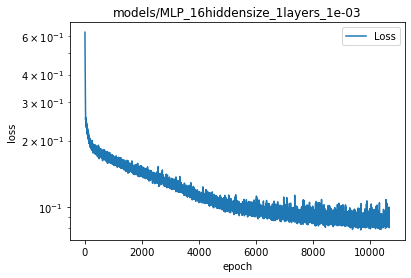

MLP_16hiddensize_1layers_1e-03
Train accuracy = 0.9631, Test accuracy = 0.9153
Train AUC = 0.9784, Test AUC = 0.8518
Epoch: 0, Loss: 6.6820e-01
Epoch: 100, Loss: 2.0291e-01
Epoch: 200, Loss: 1.8176e-01
Epoch: 300, Loss: 1.7812e-01
Epoch: 400, Loss: 1.7050e-01
Epoch: 500, Loss: 1.6257e-01
Epoch: 600, Loss: 1.6010e-01
Epoch: 700, Loss: 1.6146e-01
Epoch: 800, Loss: 1.4719e-01
Epoch: 900, Loss: 1.4845e-01
Epoch: 1000, Loss: 1.4403e-01
Epoch: 1100, Loss: 1.4241e-01
Epoch: 1200, Loss: 1.3590e-01
Epoch: 1300, Loss: 1.3632e-01
Epoch: 1400, Loss: 1.2535e-01
Epoch: 1500, Loss: 1.3018e-01
Epoch: 1600, Loss: 1.2621e-01
Epoch: 1700, Loss: 1.2553e-01
Epoch: 1800, Loss: 1.2294e-01
Epoch: 1900, Loss: 1.2318e-01
Epoch: 2000, Loss: 1.3395e-01
Epoch: 2100, Loss: 1.2824e-01
Epoch: 2200, Loss: 1.2224e-01
Epoch: 2300, Loss: 1.3514e-01
Epoch: 2400, Loss: 1.2355e-01
Epoch: 2500, Loss: 1.2035e-01
Epoch: 2600, Loss: 1.2573e-01
Epoch: 2700, Loss: 1.2071e-01
Epoch: 2800, Loss: 1.1853e-01
Epoch: 2900, Loss: 1.2148

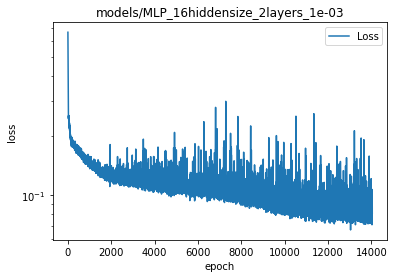

MLP_16hiddensize_2layers_1e-03
Train accuracy = 0.9661, Test accuracy = 0.9153
Train AUC = 0.9747, Test AUC = 0.8285
Epoch: 0, Loss: 6.4136e-01
Epoch: 100, Loss: 2.1299e-01
Epoch: 200, Loss: 1.8839e-01
Epoch: 300, Loss: 1.8183e-01
Epoch: 400, Loss: 1.6960e-01
Epoch: 500, Loss: 1.6250e-01
Epoch: 600, Loss: 1.4885e-01
Epoch: 700, Loss: 1.3559e-01
Epoch: 800, Loss: 9.4791e-02
Epoch: 900, Loss: 7.9708e-02
Epoch: 1000, Loss: 4.5482e-02
Epoch: 1100, Loss: 3.6415e-02
Epoch: 1200, Loss: 3.2596e-02
Epoch: 1300, Loss: 2.6347e-02
Epoch: 1400, Loss: 2.5613e-02
Epoch: 1500, Loss: 2.2110e-02
Epoch: 1600, Loss: 2.0072e-02
Epoch: 1700, Loss: 1.5034e-02
Epoch: 1800, Loss: 1.8301e-02
Epoch: 1900, Loss: 1.4258e-02
Epoch: 2000, Loss: 1.3479e-02
Epoch: 2100, Loss: 1.6204e-02
Epoch: 2200, Loss: 1.6826e-02
Epoch: 2300, Loss: 2.3586e-02
Epoch: 2400, Loss: 1.1004e-02
Epoch: 2500, Loss: 1.3900e-02
Epoch: 2600, Loss: 1.2558e-02
Epoch: 2700, Loss: 1.1138e-02
Epoch: 2800, Loss: 1.1255e-02
Epoch: 2900, Loss: 1.5341

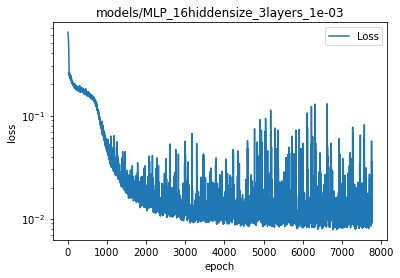

MLP_16hiddensize_3layers_1e-03
Train accuracy = 0.9985, Test accuracy = 0.8780
Train AUC = 0.9986, Test AUC = 0.7446
Epoch: 0, Loss: 7.3556e-01
Epoch: 100, Loss: 1.8820e-01
Epoch: 200, Loss: 1.7660e-01
Epoch: 300, Loss: 1.8461e-01
Epoch: 400, Loss: 1.7086e-01
Epoch: 500, Loss: 1.6981e-01
Epoch: 600, Loss: 1.7392e-01
Epoch: 700, Loss: 1.5984e-01
Epoch: 800, Loss: 1.6435e-01
Epoch: 900, Loss: 1.6411e-01
Epoch: 1000, Loss: 1.5734e-01
Epoch: 1100, Loss: 1.5977e-01
Epoch: 1200, Loss: 1.5376e-01
Epoch: 1300, Loss: 1.6141e-01
Epoch: 1400, Loss: 1.5477e-01
Epoch: 1500, Loss: 1.5836e-01
Epoch: 1600, Loss: 1.4980e-01
Epoch: 1700, Loss: 1.4502e-01
Epoch: 1800, Loss: 1.4818e-01
Epoch: 1900, Loss: 1.4319e-01
Epoch: 2000, Loss: 1.4329e-01
Epoch: 2100, Loss: 1.4346e-01
Epoch: 2200, Loss: 1.4118e-01
Epoch: 2300, Loss: 1.3757e-01
Epoch: 2400, Loss: 1.3772e-01
Epoch: 2500, Loss: 1.3866e-01
Epoch: 2600, Loss: 1.4350e-01
Epoch: 2700, Loss: 1.3710e-01
Epoch: 2800, Loss: 1.3516e-01
Epoch: 2900, Loss: 1.3246

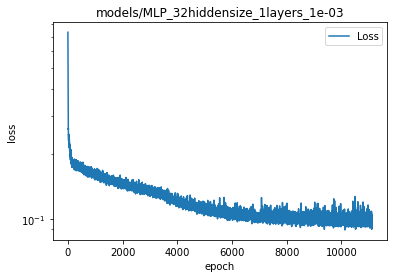

MLP_32hiddensize_1layers_1e-03
Train accuracy = 0.9558, Test accuracy = 0.9186
Train AUC = 0.9763, Test AUC = 0.8399
Epoch: 0, Loss: 6.2684e-01
Epoch: 100, Loss: 2.0826e-01
Epoch: 200, Loss: 1.9510e-01
Epoch: 300, Loss: 1.8501e-01
Epoch: 400, Loss: 1.7660e-01
Epoch: 500, Loss: 1.7503e-01
Epoch: 600, Loss: 1.6936e-01
Epoch: 700, Loss: 1.6778e-01
Epoch: 800, Loss: 1.5570e-01
Epoch: 900, Loss: 1.4795e-01
Epoch: 1000, Loss: 1.4138e-01
Epoch: 1100, Loss: 1.3504e-01
Epoch: 1200, Loss: 1.2286e-01
Epoch: 1300, Loss: 1.1193e-01
Epoch: 1400, Loss: 1.0186e-01
Epoch: 1500, Loss: 9.8559e-02
Epoch: 1600, Loss: 9.0689e-02
Epoch: 1700, Loss: 8.6417e-02
Epoch: 1800, Loss: 8.2447e-02
Epoch: 1900, Loss: 7.5455e-02
Epoch: 2000, Loss: 7.5426e-02
Epoch: 2100, Loss: 7.0981e-02
Epoch: 2200, Loss: 6.9583e-02
Epoch: 2300, Loss: 6.6663e-02
Epoch: 2400, Loss: 6.6830e-02
Epoch: 2500, Loss: 7.2542e-02
Epoch: 2600, Loss: 5.7605e-02
Epoch: 2700, Loss: 5.6204e-02
Epoch: 2800, Loss: 5.5146e-02
Epoch: 2900, Loss: 5.3002

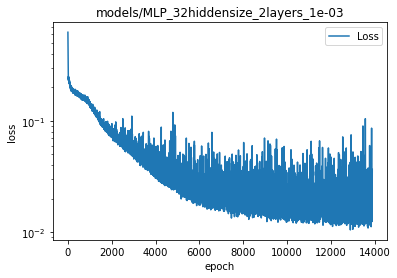

MLP_32hiddensize_2layers_1e-03
Train accuracy = 0.9764, Test accuracy = 0.9000
Train AUC = 0.9999, Test AUC = 0.7453
Epoch: 0, Loss: 7.5594e-01
Epoch: 100, Loss: 1.9615e-01
Epoch: 200, Loss: 1.8228e-01
Epoch: 300, Loss: 1.7231e-01
Epoch: 400, Loss: 1.6544e-01
Epoch: 500, Loss: 1.6307e-01
Epoch: 600, Loss: 1.4358e-01
Epoch: 700, Loss: 1.1609e-01
Epoch: 800, Loss: 7.8441e-02
Epoch: 900, Loss: 5.9504e-02
Epoch: 1000, Loss: 3.5792e-02
Epoch: 1100, Loss: 3.8891e-02
Epoch: 1200, Loss: 2.5752e-02
Epoch: 1300, Loss: 2.3283e-02
Epoch: 1400, Loss: 1.8368e-02
Epoch: 1500, Loss: 1.8373e-02
Epoch: 1600, Loss: 2.3590e-02
Epoch: 1700, Loss: 1.3659e-02
Epoch: 1800, Loss: 1.4911e-02
Epoch: 1900, Loss: 9.7904e-03
Epoch: 2000, Loss: 1.0902e-02
Epoch: 2100, Loss: 9.9572e-03
Epoch: 2200, Loss: 1.0352e-02
Epoch: 2300, Loss: 7.9435e-03
Epoch: 2400, Loss: 7.8204e-03
Epoch: 2500, Loss: 8.8239e-03
Epoch: 2600, Loss: 7.2117e-03
Epoch: 2700, Loss: 6.4276e-03
Epoch: 2800, Loss: 6.4472e-03
Epoch: 2900, Loss: 5.5893

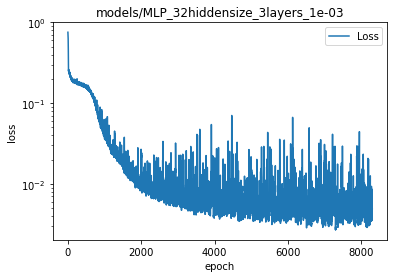

MLP_32hiddensize_3layers_1e-03
Train accuracy = 1.0000, Test accuracy = 0.8831
Train AUC = 1.0000, Test AUC = 0.8074
Epoch: 0, Loss: 7.3075e-01
Epoch: 100, Loss: 2.0251e-01
Epoch: 200, Loss: 1.8714e-01
Epoch: 300, Loss: 1.8136e-01
Epoch: 400, Loss: 1.7935e-01
Epoch: 500, Loss: 1.7505e-01
Epoch: 600, Loss: 1.6971e-01
Epoch: 700, Loss: 1.6576e-01
Epoch: 800, Loss: 1.6713e-01
Epoch: 900, Loss: 1.6143e-01
Epoch: 1000, Loss: 1.6307e-01
Epoch: 1100, Loss: 1.6976e-01
Epoch: 1200, Loss: 1.6298e-01
Epoch: 1300, Loss: 1.6056e-01
Epoch: 1400, Loss: 1.6080e-01
Epoch: 1500, Loss: 1.5828e-01
Epoch: 1600, Loss: 1.4779e-01
Epoch: 1700, Loss: 1.5304e-01
Epoch: 1800, Loss: 1.5960e-01
Epoch: 1900, Loss: 1.4884e-01
Epoch: 2000, Loss: 1.4413e-01
Epoch: 2100, Loss: 1.4427e-01
Epoch: 2200, Loss: 1.4932e-01
Epoch: 2300, Loss: 1.4253e-01
Epoch: 2400, Loss: 1.5371e-01
Epoch: 2500, Loss: 1.4232e-01
Epoch: 2600, Loss: 1.3999e-01
Epoch: 2700, Loss: 1.4609e-01
Epoch: 2800, Loss: 1.4650e-01
Epoch: 2900, Loss: 1.4615

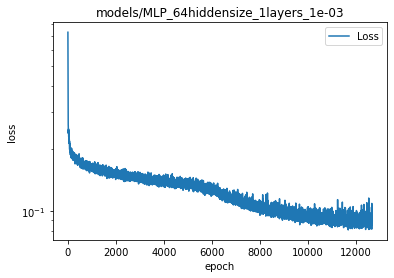

MLP_64hiddensize_1layers_1e-03
Train accuracy = 0.9587, Test accuracy = 0.9153
Train AUC = 0.9816, Test AUC = 0.8366
Epoch: 0, Loss: 6.0548e-01
Epoch: 100, Loss: 2.0275e-01
Epoch: 200, Loss: 1.9487e-01
Epoch: 300, Loss: 1.8702e-01
Epoch: 400, Loss: 1.7097e-01
Epoch: 500, Loss: 1.7159e-01
Epoch: 600, Loss: 1.6134e-01
Epoch: 700, Loss: 1.6888e-01
Epoch: 800, Loss: 1.5376e-01
Epoch: 900, Loss: 1.4456e-01
Epoch: 1000, Loss: 1.3868e-01
Epoch: 1100, Loss: 1.2595e-01
Epoch: 1200, Loss: 1.1502e-01
Epoch: 1300, Loss: 1.0085e-01
Epoch: 1400, Loss: 8.8212e-02
Epoch: 1500, Loss: 6.8711e-02
Epoch: 1600, Loss: 6.0434e-02
Epoch: 1700, Loss: 4.7447e-02
Epoch: 1800, Loss: 4.1611e-02
Epoch: 1900, Loss: 3.6684e-02
Epoch: 2000, Loss: 3.3787e-02
Epoch: 2100, Loss: 3.0134e-02
Epoch: 2200, Loss: 2.9577e-02
Epoch: 2300, Loss: 2.3202e-02
Epoch: 2400, Loss: 2.2830e-02
Epoch: 2500, Loss: 2.1786e-02
Epoch: 2600, Loss: 3.2719e-02
Epoch: 2700, Loss: 1.9621e-02
Epoch: 2800, Loss: 1.8224e-02
Epoch: 2900, Loss: 1.7274

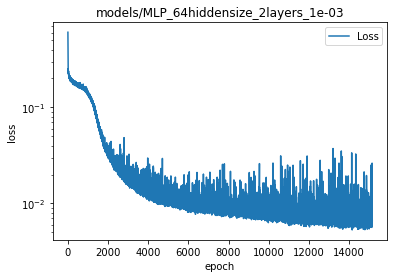

MLP_64hiddensize_2layers_1e-03
Train accuracy = 1.0000, Test accuracy = 0.8661
Train AUC = 1.0000, Test AUC = 0.7682
Epoch: 0, Loss: 7.1204e-01
Epoch: 100, Loss: 1.8669e-01
Epoch: 200, Loss: 1.7976e-01
Epoch: 300, Loss: 1.7311e-01
Epoch: 400, Loss: 1.5884e-01
Epoch: 500, Loss: 1.6199e-01
Epoch: 600, Loss: 1.4092e-01
Epoch: 700, Loss: 1.1768e-01
Epoch: 800, Loss: 8.3034e-02
Epoch: 900, Loss: 5.6012e-02
Epoch: 1000, Loss: 4.4845e-02
Epoch: 1100, Loss: 4.5066e-02
Epoch: 1200, Loss: 3.9264e-02
Epoch: 1300, Loss: 2.8931e-02
Epoch: 1400, Loss: 2.4449e-02
Epoch: 1500, Loss: 3.3254e-02
Epoch: 1600, Loss: 1.8114e-02
Epoch: 1700, Loss: 1.8616e-02
Epoch: 1800, Loss: 1.6074e-02
Epoch: 1900, Loss: 1.3384e-02
Epoch: 2000, Loss: 2.2342e-02
Epoch: 2100, Loss: 1.6173e-02
Epoch: 2200, Loss: 1.3512e-02
Epoch: 2300, Loss: 1.2637e-02
Epoch: 2400, Loss: 1.6636e-02
Epoch: 2500, Loss: 1.1569e-02
Epoch: 2600, Loss: 1.1435e-02
Epoch: 2700, Loss: 1.5025e-02
Epoch: 2800, Loss: 1.1165e-02
Epoch: 2900, Loss: 1.7818

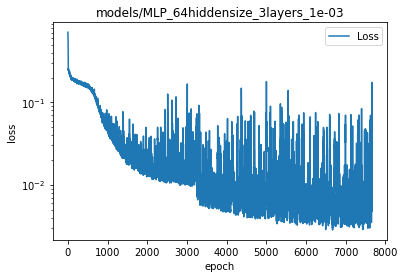

MLP_64hiddensize_3layers_1e-03
Train accuracy = 1.0000, Test accuracy = 0.8864
Train AUC = 1.0000, Test AUC = 0.7937
Epoch: 0, Loss: 6.1761e-01
Epoch: 100, Loss: 2.0578e-01
Epoch: 200, Loss: 1.9356e-01
Epoch: 300, Loss: 1.8358e-01
Epoch: 400, Loss: 1.8166e-01
Epoch: 500, Loss: 1.7775e-01
Epoch: 600, Loss: 1.6864e-01
Epoch: 700, Loss: 1.6854e-01
Epoch: 800, Loss: 1.6531e-01
Epoch: 900, Loss: 1.6457e-01
Epoch: 1000, Loss: 1.5794e-01
Epoch: 1100, Loss: 1.6273e-01
Epoch: 1200, Loss: 1.6506e-01
Epoch: 1300, Loss: 1.5475e-01
Epoch: 1400, Loss: 1.4815e-01
Epoch: 1500, Loss: 1.5169e-01
Epoch: 1600, Loss: 1.4755e-01
Epoch: 1700, Loss: 1.4504e-01
Epoch: 1800, Loss: 1.4248e-01
Epoch: 1900, Loss: 1.3994e-01
Epoch: 2000, Loss: 1.4269e-01
Epoch: 2100, Loss: 1.3308e-01
Epoch: 2200, Loss: 1.3275e-01
Epoch: 2300, Loss: 1.3201e-01
Epoch: 2400, Loss: 1.3419e-01
Epoch: 2500, Loss: 1.3070e-01
Epoch: 2600, Loss: 1.2313e-01
Epoch: 2700, Loss: 1.1776e-01
Epoch: 2800, Loss: 1.2031e-01
Epoch: 2900, Loss: 1.1759

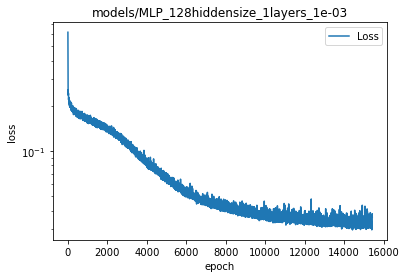

MLP_128hiddensize_1layers_1e-03
Train accuracy = 0.9808, Test accuracy = 0.9051
Train AUC = 0.9994, Test AUC = 0.8236
Epoch: 0, Loss: 6.2643e-01
Epoch: 100, Loss: 1.9428e-01
Epoch: 200, Loss: 1.7542e-01
Epoch: 300, Loss: 1.7649e-01
Epoch: 400, Loss: 1.7885e-01
Epoch: 500, Loss: 1.6705e-01
Epoch: 600, Loss: 1.6488e-01
Epoch: 700, Loss: 1.6192e-01
Epoch: 800, Loss: 1.6535e-01
Epoch: 900, Loss: 1.6247e-01
Epoch: 1000, Loss: 1.6334e-01
Epoch: 1100, Loss: 1.5434e-01
Epoch: 1200, Loss: 1.4568e-01
Epoch: 1300, Loss: 1.4581e-01
Epoch: 1400, Loss: 1.4265e-01
Epoch: 1500, Loss: 1.3914e-01
Epoch: 1600, Loss: 1.3818e-01
Epoch: 1700, Loss: 1.2743e-01
Epoch: 1800, Loss: 1.1827e-01
Epoch: 1900, Loss: 9.9002e-02
Epoch: 2000, Loss: 9.5118e-02
Epoch: 2100, Loss: 8.2766e-02
Epoch: 2200, Loss: 7.5400e-02
Epoch: 2300, Loss: 6.5969e-02
Epoch: 2400, Loss: 6.7515e-02
Epoch: 2500, Loss: 6.7468e-02
Epoch: 2600, Loss: 5.6402e-02
Epoch: 2700, Loss: 5.7784e-02
Epoch: 2800, Loss: 5.0664e-02
Epoch: 2900, Loss: 5.086

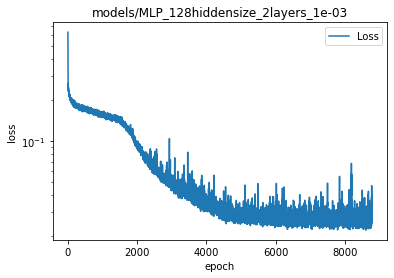

MLP_128hiddensize_2layers_1e-03
Train accuracy = 0.9941, Test accuracy = 0.8949
Train AUC = 0.9953, Test AUC = 0.7397
Epoch: 0, Loss: 7.1167e-01
Epoch: 100, Loss: 2.0485e-01
Epoch: 200, Loss: 1.7995e-01
Epoch: 300, Loss: 1.7951e-01
Epoch: 400, Loss: 1.7388e-01
Epoch: 500, Loss: 1.5754e-01
Epoch: 600, Loss: 1.4281e-01
Epoch: 700, Loss: 1.1466e-01
Epoch: 800, Loss: 8.6513e-02
Epoch: 900, Loss: 4.9572e-02
Epoch: 1000, Loss: 3.8360e-02
Epoch: 1100, Loss: 3.5189e-02
Epoch: 1200, Loss: 2.2511e-02
Epoch: 1300, Loss: 2.0228e-02
Epoch: 1400, Loss: 1.6613e-02
Epoch: 1500, Loss: 1.4526e-02
Epoch: 1600, Loss: 1.1903e-02
Epoch: 1700, Loss: 1.1084e-02
Epoch: 1800, Loss: 1.2706e-02
Epoch: 1900, Loss: 9.7448e-03
Epoch: 2000, Loss: 9.7255e-03
Epoch: 2100, Loss: 7.4802e-03
Epoch: 2200, Loss: 7.5055e-03
Epoch: 2300, Loss: 1.3947e-02
Epoch: 2400, Loss: 7.8288e-03
Epoch: 2500, Loss: 9.3263e-03
Epoch: 2600, Loss: 9.7894e-03
Epoch: 2700, Loss: 8.0657e-03
Epoch: 2800, Loss: 6.4843e-03
Epoch: 2900, Loss: 1.061

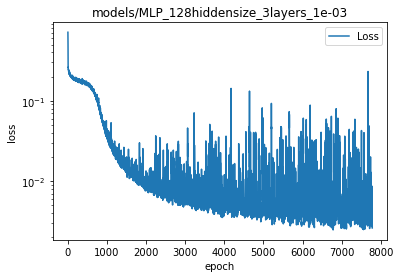

MLP_128hiddensize_3layers_1e-03
Train accuracy = 1.0000, Test accuracy = 0.8983
Train AUC = 1.0000, Test AUC = 0.8168
Epoch: 0, Loss: 7.0494e-01
Epoch: 100, Loss: 1.9801e-01
Epoch: 200, Loss: 1.8483e-01
Epoch: 300, Loss: 1.7924e-01
Epoch: 400, Loss: 1.7272e-01
Epoch: 500, Loss: 1.7542e-01
Epoch: 600, Loss: 1.6980e-01
Epoch: 700, Loss: 1.7429e-01
Epoch: 800, Loss: 1.7442e-01
Epoch: 900, Loss: 1.6454e-01
Epoch: 1000, Loss: 1.6584e-01
Epoch: 1100, Loss: 1.5768e-01
Epoch: 1200, Loss: 1.5819e-01
Epoch: 1300, Loss: 1.5509e-01
Epoch: 1400, Loss: 1.5957e-01
Epoch: 1500, Loss: 1.6011e-01
Epoch: 1600, Loss: 1.4472e-01
Epoch: 1700, Loss: 1.4697e-01
Epoch: 1800, Loss: 1.4889e-01
Epoch: 1900, Loss: 1.5150e-01
Epoch: 2000, Loss: 1.4406e-01
Epoch: 2100, Loss: 1.4095e-01
Epoch: 2200, Loss: 1.3674e-01
Epoch: 2300, Loss: 1.3255e-01
Epoch: 2400, Loss: 1.3982e-01
Epoch: 2500, Loss: 1.2951e-01
Epoch: 2600, Loss: 1.3080e-01
Epoch: 2700, Loss: 1.2803e-01
Epoch: 2800, Loss: 1.2612e-01
Epoch: 2900, Loss: 1.262

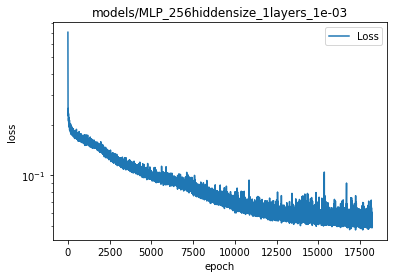

MLP_256hiddensize_1layers_1e-03
Train accuracy = 0.9661, Test accuracy = 0.9102
Train AUC = 0.9947, Test AUC = 0.8150
Epoch: 0, Loss: 6.2176e-01
Epoch: 100, Loss: 1.9193e-01
Epoch: 200, Loss: 1.8307e-01
Epoch: 300, Loss: 1.7349e-01
Epoch: 400, Loss: 1.7161e-01
Epoch: 500, Loss: 1.7091e-01
Epoch: 600, Loss: 1.6370e-01
Epoch: 700, Loss: 1.5571e-01
Epoch: 800, Loss: 1.6209e-01
Epoch: 900, Loss: 1.4968e-01
Epoch: 1000, Loss: 1.5784e-01
Epoch: 1100, Loss: 1.3696e-01
Epoch: 1200, Loss: 1.1854e-01
Epoch: 1300, Loss: 9.7624e-02
Epoch: 1400, Loss: 9.1975e-02
Epoch: 1500, Loss: 7.2083e-02
Epoch: 1600, Loss: 5.9511e-02
Epoch: 1700, Loss: 4.6923e-02
Epoch: 1800, Loss: 3.5917e-02
Epoch: 1900, Loss: 3.1298e-02
Epoch: 2000, Loss: 2.7328e-02
Epoch: 2100, Loss: 2.2950e-02
Epoch: 2200, Loss: 2.2815e-02
Epoch: 2300, Loss: 1.8345e-02
Epoch: 2400, Loss: 1.9725e-02
Epoch: 2500, Loss: 1.7664e-02
Epoch: 2600, Loss: 1.5170e-02
Epoch: 2700, Loss: 1.4367e-02
Epoch: 2800, Loss: 1.3719e-02
Epoch: 2900, Loss: 1.406

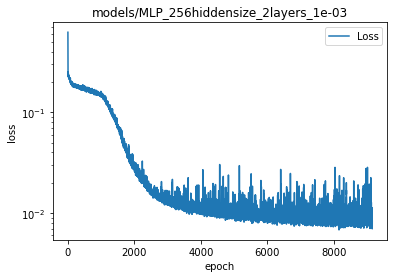

MLP_256hiddensize_2layers_1e-03
Train accuracy = 1.0000, Test accuracy = 0.8864
Train AUC = 1.0000, Test AUC = 0.7863
Epoch: 0, Loss: 6.5871e-01
Epoch: 100, Loss: 1.9926e-01
Epoch: 200, Loss: 1.8101e-01
Epoch: 300, Loss: 1.7929e-01
Epoch: 400, Loss: 1.6784e-01
Epoch: 500, Loss: 1.5606e-01
Epoch: 600, Loss: 1.3978e-01
Epoch: 700, Loss: 9.9281e-02
Epoch: 800, Loss: 5.6001e-02
Epoch: 900, Loss: 3.8613e-02
Epoch: 1000, Loss: 3.0469e-02
Epoch: 1100, Loss: 2.6345e-02
Epoch: 1200, Loss: 2.3595e-02
Epoch: 1300, Loss: 1.7704e-02
Epoch: 1400, Loss: 1.9208e-02
Epoch: 1500, Loss: 2.1081e-02
Epoch: 1600, Loss: 1.4148e-02
Epoch: 1700, Loss: 2.3301e-02
Epoch: 1800, Loss: 1.5952e-02
Epoch: 1900, Loss: 1.2759e-02
Epoch: 2000, Loss: 1.1996e-02
Epoch: 2100, Loss: 1.2454e-02
Epoch: 2200, Loss: 1.4531e-02
Epoch: 2300, Loss: 1.1705e-02
Epoch: 2400, Loss: 1.3113e-02
Epoch: 2500, Loss: 1.3740e-02
Epoch: 2600, Loss: 8.5132e-03
Epoch: 2700, Loss: 8.8715e-03
Epoch: 2800, Loss: 1.2495e-02
Epoch: 2900, Loss: 6.259

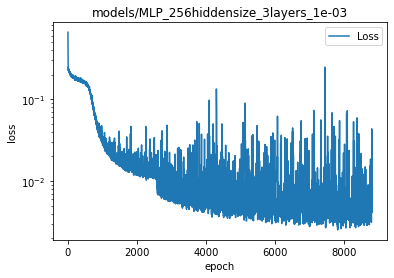

MLP_256hiddensize_3layers_1e-03
Train accuracy = 1.0000, Test accuracy = 0.8847
Train AUC = 1.0000, Test AUC = 0.7263


In [22]:
criterion = nn.BCEWithLogitsLoss()

for weight_decay in [1e-3]:
    for hidden_size in [16, 32, 64, 128, 256]:
        for num_layer in [1, 2, 3]:
            
            
            
            path = './models/MLP_{}hiddensize_{}layers_{:.0e}'.format(hidden_size, num_layer, weight_decay)
            #if os.path.isfile(path):
            #    continue

            model = MLP(input_size=total_train.shape[-1], hidden_size=hidden_size, num_layer=num_layer, num_event=num_event).to(device)
            #if os.path.isfile(path):
            #    model.load_state_dict(torch.load(path, map_location = device))

            lr = 1e-3
            optimizer = adabound.AdaBound(model.parameters(), lr=lr, weight_decay=0)

            loss_array = []
            patience = 0
            min_loss = np.inf
            for e in range(int(1e6)):

                loss_array_tmp = []

                for total_batch, timevar_compact_batch, event_batch, time_batch, obs_mask_batch in train_loader:

                    total_batch = total_batch.float()
                    event_batch = event_batch.reshape(-1,1).float()

                    y_pred = model(total_batch.to(device))

                    norm = 0.
                    for parameter in model.parameters():
                        norm += torch.norm(parameter, p=1)

                    loss1 = criterion(y_pred, event_batch.to(device))

                    loss = loss1 + weight_decay*norm
                    loss_array_tmp.append(loss1.item())

                    model.zero_grad()

                    loss.backward()

                    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
                    optimizer.step()

                loss_array.append(np.mean(loss_array_tmp))
                if e % 100 == 0:
                    print('Epoch: ' + str(e) + 
                          ', Loss: '+ f'{loss_array[-1]:.4e}')
                if min_loss > loss_array[-1]:
                    patience = 0
                    min_loss = loss_array[-1]
                    torch.save(model.state_dict(), path)
                else:
                    patience += 1

                torch.cuda.empty_cache()

                if patience > 1000:
                    break

            plt.plot(loss_array, label='Loss')
            plt.ylabel('loss')
            plt.xlabel('epoch')
            plt.yscale('log')
            plt.title(path[2:])
            plt.legend()
            plt.show()

            total_train_sort = torch.FloatTensor(total_train)
            total_test_sort = torch.FloatTensor(total_test)

            model.load_state_dict(torch.load(path, map_location = device))

            y_train = torch.sigmoid(model(total_train_sort.to(device))).detach().cpu().numpy()
            y_test = torch.sigmoid(model(total_test_sort.to(device))).detach().cpu().numpy()

            out_pred = np.where(y_train >= 0.5, 1, 0)
            acc_train = accuracy_score(event_train, out_pred.flatten())
            auc_train = roc_auc_score(event_train, y_train.flatten())
            
            out_pred = np.where(y_test >= 0.5, 1, 0)
            acc_test = accuracy_score(event_test, out_pred.flatten())
            auc_test = roc_auc_score(event_test, y_test.flatten())
            
            print(path[9:])
            print('Train accuracy = {:.4f}, Test accuracy = {:.4f}'.format(acc_train, acc_test))
            print('Train AUC = {:.4f}, Test AUC = {:.4f}'.format(auc_train, auc_test))

In [23]:
for weight_decay in [1e-3]:
    for hidden_size in [16, 32, 64, 128, 256]:
        for num_layer in [1, 2, 3]:

            path = './models/MLP_{}hiddensize_{}layers_{:.0e}'.format(hidden_size, num_layer, weight_decay)
            #if os.path.isfile(path):
            #    continue

            model = MLP(input_size=total_train.shape[-1], hidden_size=hidden_size, num_layer=num_layer, num_event=num_event).to(device)
            #if os.path.isfile(path):
            #    model.load_state_dict(torch.load(path, map_location = device))

            total_train_sort = torch.FloatTensor(total_train)
            total_test_sort = torch.FloatTensor(total_test)

            model.load_state_dict(torch.load(path, map_location = device))

            y_train = torch.sigmoid(model(total_train_sort.to(device))).detach().cpu().numpy()
            y_test = torch.sigmoid(model(total_test_sort.to(device))).detach().cpu().numpy()
            
            out_pred = np.where(y_train >= 0.5, 1, 0)
            acc_train = accuracy_score(event_train, out_pred.flatten())
            auc_train = roc_auc_score(event_train, y_train.flatten())
            
            out_pred = np.where(y_test >= 0.5, 1, 0)
            acc_test = accuracy_score(event_test, out_pred.flatten())
            auc_test = roc_auc_score(event_test, y_test.flatten())
            
            print(path[9:])
            print('Train accuracy = {:.4f}, Test accuracy = {:.4f}'.format(acc_train, acc_test))
            print('Train AUC = {:.4f}, Test AUC = {:.4f}\n'.format(auc_train, auc_test))

MLP_16hiddensize_1layers_1e-03
Train accuracy = 0.9631, Test accuracy = 0.9153
Train AUC = 0.9784, Test AUC = 0.8518

MLP_16hiddensize_2layers_1e-03
Train accuracy = 0.9661, Test accuracy = 0.9153
Train AUC = 0.9747, Test AUC = 0.8285

MLP_16hiddensize_3layers_1e-03
Train accuracy = 0.9985, Test accuracy = 0.8780
Train AUC = 0.9986, Test AUC = 0.7446

MLP_32hiddensize_1layers_1e-03
Train accuracy = 0.9558, Test accuracy = 0.9186
Train AUC = 0.9763, Test AUC = 0.8399

MLP_32hiddensize_2layers_1e-03
Train accuracy = 0.9764, Test accuracy = 0.9000
Train AUC = 0.9999, Test AUC = 0.7453

MLP_32hiddensize_3layers_1e-03
Train accuracy = 1.0000, Test accuracy = 0.8831
Train AUC = 1.0000, Test AUC = 0.8074

MLP_64hiddensize_1layers_1e-03
Train accuracy = 0.9587, Test accuracy = 0.9153
Train AUC = 0.9816, Test AUC = 0.8366

MLP_64hiddensize_2layers_1e-03
Train accuracy = 1.0000, Test accuracy = 0.8661
Train AUC = 1.0000, Test AUC = 0.7682

MLP_64hiddensize_3layers_1e-03
Train accuracy = 1.0000, 